<b>PREDICT TEMPERATURE!</b><br>
--
AUTHOR : HAMORA HADI

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

<b>IMPORT THE DATA</b><br>
Kita akan melakukan import data.<br>
Di sini data berbentuk csv, maka kita akan menggunakan library <i>csv</i>

In [2]:
import csv

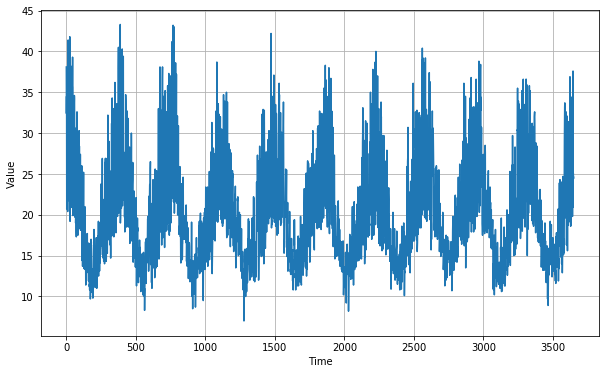

In [3]:
time_step = []
temps = []

with open('C:/Users/User/Desktop/Security_Info/daily-max-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Lalu kita set variabel untuk digunakan dalam fungsi wajib, <b>windowed_dataset</b>

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

<b>BUILD YOUR MODEL FROM SCRATCH!</b>

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
#Setel epoch nya sebanyak 100!
#Biar kita bisa tau SME nya!
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 1s 134ms/step - loss: 36.4810 - mae: 36.9797
Epoch 2/100
10/10 [==============================] - 1s 134ms/step - loss: 34.9676 - mae: 35.4661
Epoch 3/100
10/10 [==============================] - 1s 133ms/step - loss: 32.9296 - mae: 33.4281
Epoch 4/100
10/10 [==============================] - 1s 127ms/step - loss: 30.8487 - mae: 31.3472
Epoch 5/100
10/10 [==============================] - 1s 130ms/step - loss: 28.7841 - mae: 29.2826
Epoch 6/100
10/10 [==============================] - 1s 124ms/step - loss: 26.6697 - mae: 27.1682
Epoch 7/100
10/10 [==============================] - 1s 126ms/step - loss: 24.4405 - mae: 24.9389
Epoch 8/100
10/10 [==============================] - 1s 128ms/step - loss: 22.0019 - mae: 22.5001
Epoch 9/100
10/10 [==============================] - 2s 157ms/step - loss: 19.3319 - mae: 19.8296
Epoch 10/100
10/

10/10 [==============================] - 2s 150ms/step - loss: 5.4888 - mae: 5.9720
Epoch 84/100
10/10 [==============================] - 1s 150ms/step - loss: 5.0531 - mae: 5.5327
Epoch 85/100
10/10 [==============================] - 1s 148ms/step - loss: 7.0594 - mae: 7.5461
Epoch 86/100
10/10 [==============================] - 1s 148ms/step - loss: 6.1796 - mae: 6.6625
Epoch 87/100
10/10 [==============================] - 1s 148ms/step - loss: 6.0053 - mae: 6.4870
Epoch 88/100
10/10 [==============================] - 1s 148ms/step - loss: 15.0746 - mae: 15.5659
Epoch 89/100
10/10 [==============================] - 1s 148ms/step - loss: 15.3307 - mae: 15.8211
Epoch 90/100
10/10 [==============================] - 1s 148ms/step - loss: 9.5834 - mae: 10.0730
Epoch 91/100
10/10 [==============================] - 2s 150ms/step - loss: 16.8896 - mae: 17.3800
Epoch 92/100
10/10 [==============================] - 1s 149ms/step - loss: 10.5196 - mae: 11.0098
Epoch 93/100
10/10 [==============

Coba kita visualkan!

[1e-08, 0.0001, 0, 60]

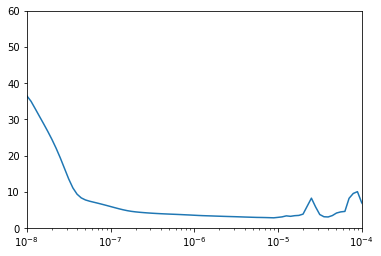

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Kita akan train sekali lagi, tapi dengan jangkauan epochs sedikit lebih banyak.<br>
Yakni tambahan 50%!

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 2s 62ms/step - loss: 13.4936 - mae: 13.9857
Epoch 2/150
25/25 [==============================] - 2s 63ms/step - loss: 3.8422 - mae: 4.3140
Epoch 3/150
25/25 [==============================] - 2s 62ms/step - loss: 3.1223 - mae: 3.5871
Epoch 4/150
25/25 [==============================] - 2s 65ms/step - loss: 3.0264 - mae: 3.4908
Epoch 5/150
25/25 [==============================] - 2s 67ms/step - loss: 2.9613 - mae: 3.4253
Epoch 6/150
25/25 [==============================] - 2s 66ms/step - loss: 2.8986 - mae: 3.3618
Epoch 7/150
25/25 [==============================] - 2s 66ms/step - loss: 2.8505 - mae: 3.3129
Epoch 8/150
25/25 [==============================] - 2s 63ms/step - loss: 2.7955 - mae: 3.2566
Epoch 9/150
25/25 [==============================] - 2s 62ms/step - loss: 2.7582 - mae: 3.2188
Epoch 10/150
25/25 [==============================] - 2s 62ms/step - loss: 2.7180 - mae: 3.1781
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 2s 75ms/step - loss: 2.4088 - mae: 2.8629
Epoch 86/150
25/25 [==============================] - 2s 76ms/step - loss: 2.3963 - mae: 2.8505
Epoch 87/150
25/25 [==============================] - 2s 75ms/step - loss: 2.3877 - mae: 2.8412
Epoch 88/150
25/25 [==============================] - 2s 74ms/step - loss: 2.3856 - mae: 2.8395
Epoch 89/150
25/25 [==============================] - 2s 75ms/step - loss: 2.3868 - mae: 2.8408
Epoch 90/150
25/25 [==============================] - 2s 74ms/step - loss: 2.3887 - mae: 2.8427
Epoch 91/150
25/25 [==============================] - 2s 74ms/step - loss: 2.3939 - mae: 2.8478
Epoch 92/150
25/25 [==============================] - 2s 73ms/step - loss: 2.3862 - mae: 2.8400
Epoch 93/150
25/25 [==============================] - 2s 74ms/step - loss: 2.3889 - mae: 2.8429
Epoch 94/150
25/25 [==============================] - 2s 75ms/step - loss: 2.3858 - mae: 2.8396
Epoch 95/150
25/25 [==============================] -

In [15]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

Kita visualkan hasil yang sudah diperoleh

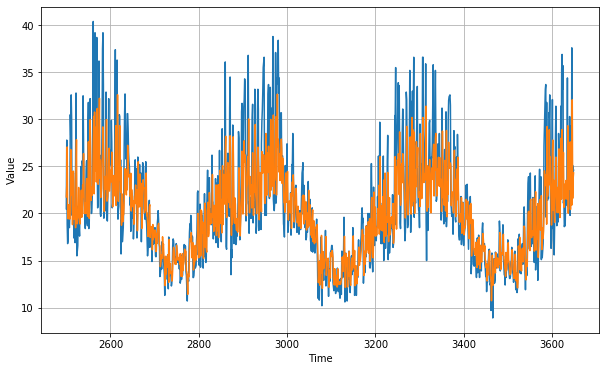

In [16]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

<b>MAE</b>
--

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.8210745

In [18]:
print(rnn_forecast)

[21.766045 22.921728 27.067179 ... 21.61095  23.723198 24.305109]
